# Exploring ERA GPM IMERG early and late prdct an ERA5 for the OpenMRG2 dataset

### open points (I'd suggest to change for openMRG2)
* era5 time is called valid_time --> change to time
* era5 rainfall is in meters --> change to mm
* gpm time format cannot directly be used by xarray plotting --> change to np.datetime64
* gpm is mm/h for 30 min timesteps, era is hourly anyway --> change to gpm to mm

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!curl -L -o gpm_imerg_early.nc "https://drive.usercontent.google.com/download?id=1-Lq2t_3em0EAC4i5MtlZoanz2_Nv1_Wl&confirm=yes"
!curl -L -o gpm_imerg_final.nc "https://drive.usercontent.google.com/download?id=1Igq919rtTZGYoEVnJisI9pp2qN7iPc7a&confirm=yes"
!curl -L -o era5.nc "https://drive.usercontent.google.com/download?id=1MaS8n71vuEjnvFUEejnViaoZpyhOxqWT&confirm=yes"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1458k  100 1458k    0     0  1135k      0  0:00:01  0:00:01 --:--:-- 1135k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1458k  100 1458k    0     0   903k      0  0:00:01  0:00:01 --:--:--  903k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5864k  100 5864k    0     0  4027k      0  0:00:01  0:00:01 --:--:-- 4027k


In [3]:
ds_gpm_imerg_early = xr.open_dataset("gpm_imerg_early.nc")
ds_gpm_imerg_final = xr.open_dataset("gpm_imerg_final.nc")
ds_era5 = xr.open_dataset("era5.nc")

In [4]:
ds_gpm_imerg_early = ds_gpm_imerg_early.assign_coords(
    time=np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in ds_gpm_imerg_early.time.values])
 )
ds_gpm_imerg_final = ds_gpm_imerg_final.assign_coords(
    time=np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in ds_gpm_imerg_final.time.values])
 )

/tmp/ipykernel_1804310/169426600.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_gpm_imerg_early = ds_gpm_imerg_early.assign_coords(
/tmp/ipykernel_1804310/169426600.py:4: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the val

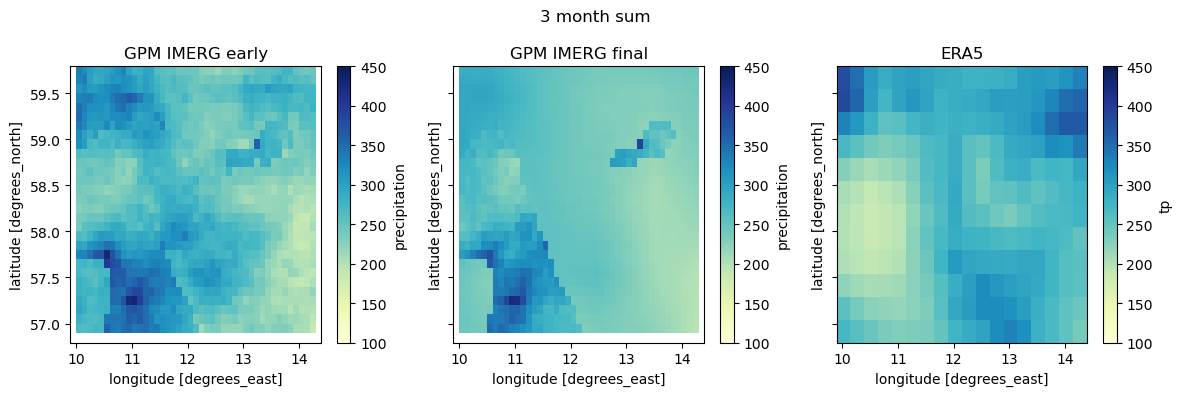

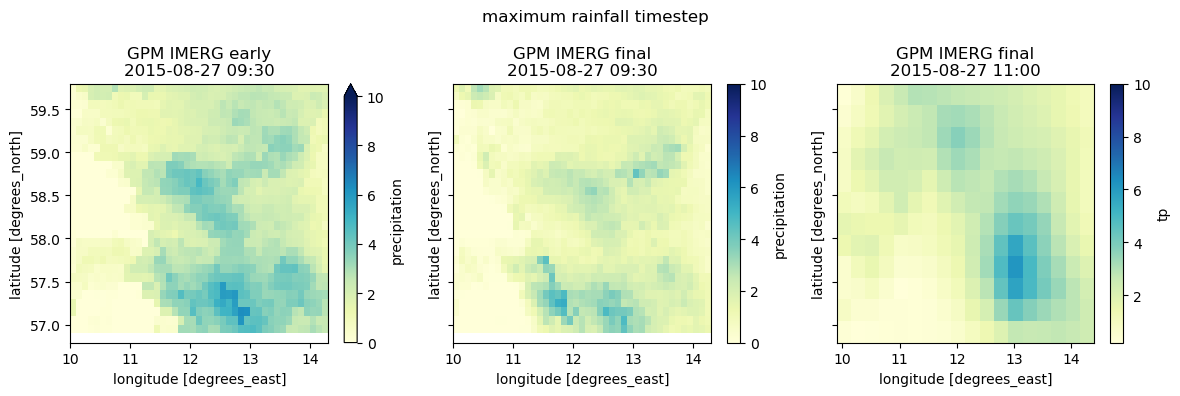

In [5]:
# three month sum
fig,ax=plt.subplots(1,3,figsize=(12,4),sharey=True,sharex=True)
(ds_gpm_imerg_early.precipitation.sum(dim='time')/2).plot(ax=ax[0],x='lon',y='lat',vmin=100,vmax=450,cmap='YlGnBu')
(ds_gpm_imerg_final.precipitation.sum(dim='time')/2).plot(ax=ax[1],x='lon',y='lat',vmin=100,vmax=450,cmap='YlGnBu')
(ds_era5.tp.sum(dim='valid_time')*1000).plot(ax=ax[2],vmin=100,vmax=450,cmap='YlGnBu')
ax[0].set_title("GPM IMERG early")
ax[1].set_title("GPM IMERG final")
ax[2].set_title("ERA5")
fig.suptitle('3 month sum')
plt.tight_layout()

# timestep with max rainfall
early_max_ts = ds_gpm_imerg_early.precipitation.sum(dim=['lon','lat']).idxmax()
final_max_ts = ds_gpm_imerg_final.precipitation.sum(dim=['lon','lat']).idxmax()
era5_max_ts = ds_era5.tp.sum(dim=['longitude','latitude']).idxmax()


fig,ax=plt.subplots(1,3,figsize=(12,4),sharey=True)
(ds_gpm_imerg_early.precipitation.sel(time=early_max_ts)/2).plot(ax=ax[0],x='lon',y='lat',vmax=10,cmap='YlGnBu')
(ds_gpm_imerg_final.precipitation.sel(time=final_max_ts)/2).plot(ax=ax[1],x='lon',y='lat',vmax=10,cmap='YlGnBu')
(ds_era5.tp*1000).sel(valid_time=era5_max_ts).plot(ax=ax[2],vmax=10,cmap='YlGnBu')
ax[0].set_title("GPM IMERG early\n"+str(early_max_ts.values.astype('M8[ms]').item().strftime('%Y-%m-%d %H:%M')))
ax[1].set_title("GPM IMERG final\n"+str(final_max_ts.values.astype('M8[ms]').item().strftime('%Y-%m-%d %H:%M')))
ax[2].set_title("GPM IMERG final\n"+str(era5_max_ts.values.astype('M8[ms]').item().strftime('%Y-%m-%d %H:%M')))
fig.suptitle('maximum rainfall timestep')
plt.tight_layout();

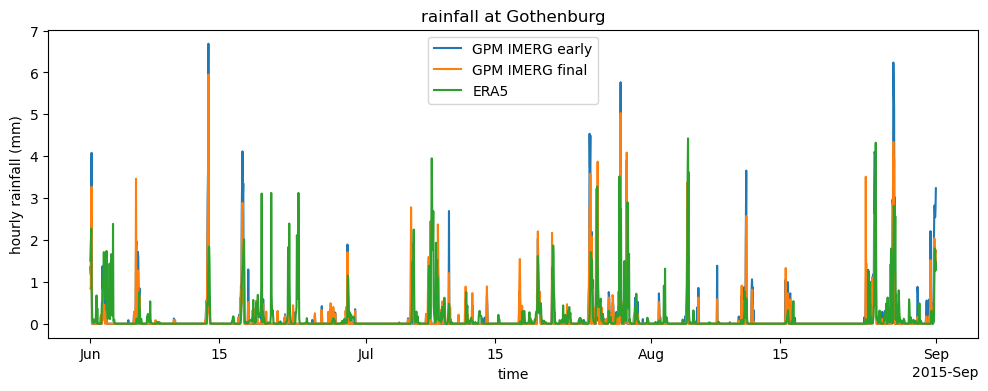

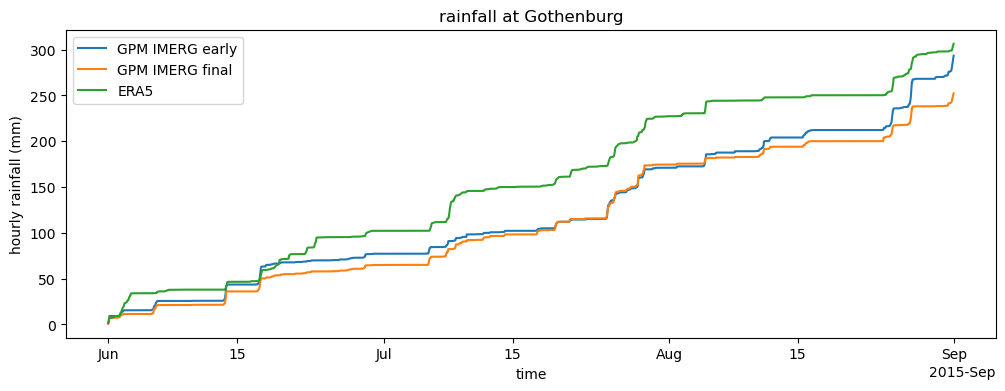

In [6]:
ds_gpm_imerg_early.sel(lon=11.9675,lat=57.7075,method='nearest').precipitation.resample(time='1h').mean().plot(label='GPM IMERG early',figsize=(12,4))
ds_gpm_imerg_final.sel(lon=11.9675,lat=57.7075,method='nearest').precipitation.resample(time='1h').mean().plot(label='GPM IMERG final')
(ds_era5.sel(longitude=11.9675,latitude=57.7075,method='nearest').tp*1000).plot(label='ERA5')
plt.legend()
plt.title('rainfall at Gothenburg')
plt.ylabel("hourly rainfall (mm)")

ds_gpm_imerg_early.sel(lon=11.9675,lat=57.7075,method='nearest').precipitation.resample(time='1h').mean().cumsum().plot(label='GPM IMERG early',figsize=(12,4))
ds_gpm_imerg_final.sel(lon=11.9675,lat=57.7075,method='nearest').precipitation.resample(time='1h').mean().cumsum().plot(label='GPM IMERG final')
(ds_era5.sel(longitude=11.9675,latitude=57.7075,method='nearest').tp*1000).cumsum().plot(label='ERA5')
plt.legend()
plt.title('rainfall at Gothenburg')
plt.ylabel("hourly rainfall (mm)");